In [1]:
import pandas as pd
import csv
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Root_Insurance_data.csv",delimiter = ",")

In [62]:
## Input: Data Frame (in the format of "Root_Insurance_data.csv") and encode_rank (default = False)
## Output: Data Frame (processed by one hot encoding ready to be used to make models)

## This function will one hot encode the following columns in the data frame: 
## Currently Insured, Marital Status, click, rank (optional, determined by encode_rank = True)
## and will drop the respective columns associated to the respective values of above columns:
## unknown, S, False, 5.0 (if encode_rank = True)

import category_encoders as ce

def prepare_data(data:pd.DataFrame(), encode_rank = False) -> pd.DataFrame():
    temp = data.copy()
    
    if encode_rank:
        one_hot_cols = ["Currently Insured", "Marital Status", "click", "rank"]
        drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0", "click_False"]
        column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                        'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                        'rank_2.0', 'rank_3.0', 'rank_4.0', 'click_True', 'policies_sold']
    else:
        one_hot_cols = ["Currently Insured", "Marital Status", "click"]
        drop_cols = ["Currently Insured_unknown", "Marital Status_S", "click_False"]
        column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                        'Marital Status_M', 'bid', 'rank', 'click_True', 'policies_sold']
    
    encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
    temp = encoder.fit_transform(temp)
    temp = temp.drop(columns = drop_cols)
    temp = temp.reindex(columns=column_names)
    return temp

In [63]:
df = prepare_data(data)

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [64]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score

features = ['Currently Insured_Y',
            'Currently Insured_N',
            'Number of Vehicles',
            'Number of Drivers',
            'Marital Status_M',
            'bid',
            'rank']
predictor_var = ["click_True"]

df_train, df_test = train_test_split(df,
                                     shuffle=True,
                                     random_state=12345,
                                     test_size=.2,
                                     stratify=df[predictor_var])

In [77]:
## Baseline Model: Biased coinflip with probability of landing 1 the average of the clicks in the 10000 data
np.random.seed(12345)
rand_prob = np.random.rand(8000)
threshold = np.average(df[predictor_var])
baseline = np.array([int(x < threshold) for x in rand_prob])

In [89]:
num_of_splits = 5

avg_precision_cross_val = np.zeros(num_of_splits) 
roc_auc_cross_val = np.zeros(num_of_splits) 
accuracy_cross_val = np.zeros(num_of_splits) 

kfold = StratifiedKFold(n_splits=num_of_splits, shuffle=True, random_state=77)

i = 0
for train_index, test_index in kfold.split(df_train[features], df_train[predictor_var]):
    df_train_train = df_train.iloc[train_index]
    df_train_val = df_train.iloc[test_index]
    y_actual = np.array(df_train_val[predictor_var]).reshape(1,-1)[0]
    
    avg_precision_cross_val[i] = average_precision_score(y_actual, baseline[test_index])
    roc_auc_cross_val[i] = roc_auc_score(y_actual, baseline[test_index])
    accuracy_cross_val[i] = accuracy_score(y_actual, baseline[test_index])
 
    i += 1

In [95]:
print("The average cross validation of the average precision score is: " + str(np.average(avg_precision_cross_val)))
print("The average cross validation of the AUCROC score is: " + str(np.average(roc_auc_cross_val)))
print("The average cross validation of the accuracy score is: " + str(np.average(accuracy_cross_val)))

The average cross validation of the average precision score is: 0.18760303872980139
The average cross validation of the AUCROC score is: 0.499193727625115
The average cross validation of the accuracy score is: 0.695375


In [97]:
precision, recall, threshold = precision_recall_curve(np.array(df_train[predictor_var]).reshape(1,-1)[0], 
                                                      baseline)

Text(0.5, 1.0, 'Precision Recall Curve')

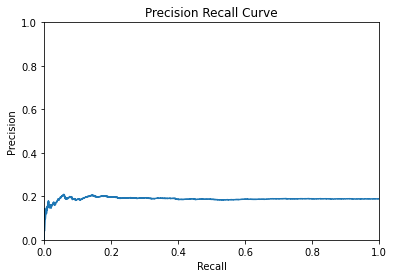

In [109]:
np.random.seed(12345)
precision, recall, threshold = precision_recall_curve(np.array(df_train[predictor_var]).reshape(1,-1)[0], 
                                                      np.random.rand(8000))
plt.plot(recall[:-1], precision[:-1], label = 'baseline')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim(0,1)
plt.xlim(0,1)
plt.title("Precision Recall Curve")